## Create ML model using RANDOM FOREST algorithm for self-driving car with LIDAR data

In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

## 1. Loading the data

In [2]:
# read data from csv
data = pd.read_csv('../data/simulation/lidar_training_data_20250727_095526_half.csv', header=None)
data.shape

(945, 361)

In [3]:
# Take a look at the dataframe
data

,0,1,2,3,4,5,6,7,8,9,...,351,352,353,354,355,356,357,358,359,360
0,1.874574,1.840124,1.807461,1.776471,1.747052,1.719108,1.692555,1.667311,1.643305,1.620469,...,2.241759,2.186523,2.134649,2.085887,2.039914,1.996521,1.955522,1.916747,1.880045,-0.20
1,1.774570,1.741958,1.711038,1.681701,1.653851,1.627398,1.602261,1.578364,1.555639,1.534021,...,2.122052,2.069727,2.020710,1.974551,1.931032,1.889955,1.851144,1.814440,1.779696,-0.15
2,1.674567,1.643793,1.614614,1.586931,1.560651,1.535689,1.511968,1.489418,1.467973,1.447574,...,2.002346,1.953009,1.906771,1.863215,1.822150,1.783389,1.746767,1.712132,1.679347,-0.15
3,1.574563,1.545627,1.518191,1.492161,1.467450,1.443979,1.421675,1.400471,1.380307,1.361126,...,1.882639,1.836322,1.792833,1.751879,1.713268,1.676823,1.642389,1.609824,1.578998,-0.25
4,1.474560,1.447461,1.421768,1.397391,1.374250,1.352269,1.331382,1.311525,1.292641,1.274678,...,1.762923,1.719620,1.678894,1.640544,1.604386,1.570258,1.538012,1.507516,1.478649,-0.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
940,2.955912,2.913553,2.868310,2.746274,2.634972,2.533086,2.439503,2.353284,2.273623,2.199830,...,3.400095,3.335169,3.273659,3.215343,3.160018,3.107500,3.057619,3.010220,2.965163,-0.40
941,3.118309,3.064178,3.012802,2.964011,2.917655,2.873591,2.831693,2.791841,2.708428,2.596038,...,3.692614,3.607174,3.526654,3.450682,3.378927,3.311088,3.246894,3.186097,3.128475,-0.40
942,3.222933,3.159849,3.100118,3.043518,2.989845,2.938917,2.890564,2.844633,2.800982,2.759483,...,3.797215,3.738487,3.682657,3.613146,3.528150,3.448092,3.372596,3.301324,3.233970,0.00
943,3.123431,3.062279,3.004377,2.949510,2.897482,2.848114,2.801242,2.756719,2.714406,2.674178,...,3.685606,3.628594,3.574396,3.501443,3.419060,3.341464,3.268290,3.199210,3.133929,0.00


## 2. Data Preprocessing

In [4]:
# Impute value of 0, Makeup data with 0 distance the average of 2 adjacent values
def cleanup_zero_distances(data):
    for i in range(data.shape[0]):
        for j in range(data.shape[1] - 1): # skip the last column as it is the Turn value
            if data.iloc[i, j] == 0:
                # get right side value
                k = j # set column position at j
                left_val = right_val = 0
                while k < data.shape[1]: # keep finding until found non zero value
                    if data.iloc[i, k] > 0:
                        right_val = data.iloc[i, k]
                        break
                    k = k + 1
                # get the left side value
                left_val = right_val
                k = j # set column position at j
                while k >= 0: # keep finding until found non zero value
                    if data.iloc[i, k] > 0:
                        left_val = data.iloc[i, k]
                        break
                    k = k - 1
                data.iat[i, j] = (left_val + right_val) / 2
cleanup_zero_distances(data)
data

,0,1,2,3,4,5,6,7,8,9,...,351,352,353,354,355,356,357,358,359,360
0,1.874574,1.840124,1.807461,1.776471,1.747052,1.719108,1.692555,1.667311,1.643305,1.620469,...,2.241759,2.186523,2.134649,2.085887,2.039914,1.996521,1.955522,1.916747,1.880045,-0.20
1,1.774570,1.741958,1.711038,1.681701,1.653851,1.627398,1.602261,1.578364,1.555639,1.534021,...,2.122052,2.069727,2.020710,1.974551,1.931032,1.889955,1.851144,1.814440,1.779696,-0.15
2,1.674567,1.643793,1.614614,1.586931,1.560651,1.535689,1.511968,1.489418,1.467973,1.447574,...,2.002346,1.953009,1.906771,1.863215,1.822150,1.783389,1.746767,1.712132,1.679347,-0.15
3,1.574563,1.545627,1.518191,1.492161,1.467450,1.443979,1.421675,1.400471,1.380307,1.361126,...,1.882639,1.836322,1.792833,1.751879,1.713268,1.676823,1.642389,1.609824,1.578998,-0.25
4,1.474560,1.447461,1.421768,1.397391,1.374250,1.352269,1.331382,1.311525,1.292641,1.274678,...,1.762923,1.719620,1.678894,1.640544,1.604386,1.570258,1.538012,1.507516,1.478649,-0.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
940,2.955912,2.913553,2.868310,2.746274,2.634972,2.533086,2.439503,2.353284,2.273623,2.199830,...,3.400095,3.335169,3.273659,3.215343,3.160018,3.107500,3.057619,3.010220,2.965163,-0.40
941,3.118309,3.064178,3.012802,2.964011,2.917655,2.873591,2.831693,2.791841,2.708428,2.596038,...,3.692614,3.607174,3.526654,3.450682,3.378927,3.311088,3.246894,3.186097,3.128475,-0.40
942,3.222933,3.159849,3.100118,3.043518,2.989845,2.938917,2.890564,2.844633,2.800982,2.759483,...,3.797215,3.738487,3.682657,3.613146,3.528150,3.448092,3.372596,3.301324,3.233970,0.00
943,3.123431,3.062279,3.004377,2.949510,2.897482,2.848114,2.801242,2.756719,2.714406,2.674178,...,3.685606,3.628594,3.574396,3.501443,3.419060,3.341464,3.268290,3.199210,3.133929,0.00


In [5]:
# get augmented data
def get_augmented_data(data):
    augmented_data = np.zeros(data.shape)
    for i in range(augmented_data.shape[0]):
        for j in range(augmented_data.shape[1]):
            augmented_data[i, j] = data.iloc[i, 359 - j]
        augmented_data[i, 360] = round(0 - float(data.iloc[i, 360]),2)
    
    return pd.DataFrame(augmented_data)
augmented_data = get_augmented_data(data)
augmented_data

,0,1,2,3,4,5,6,7,8,9,...,351,352,353,354,355,356,357,358,359,360
0,1.880045,1.916747,1.955522,1.996521,2.039914,2.085887,2.134649,2.186523,2.241759,2.300580,...,1.643305,1.667311,1.692555,1.719108,1.747052,1.776471,1.807461,1.840124,1.874574,0.20
1,1.779696,1.814440,1.851144,1.889955,1.931032,1.974551,2.020710,2.069727,2.122052,2.177732,...,1.555639,1.578364,1.602261,1.627398,1.653851,1.681701,1.711038,1.741958,1.774570,0.15
2,1.679347,1.712132,1.746767,1.783389,1.822150,1.863215,1.906771,1.953009,2.002346,2.054885,...,1.467973,1.489418,1.511968,1.535689,1.560651,1.586931,1.614614,1.643793,1.674567,0.15
3,1.578998,1.609824,1.642389,1.676823,1.713268,1.751879,1.792833,1.836322,1.882639,1.932038,...,1.380307,1.400471,1.421675,1.443979,1.467450,1.492161,1.518191,1.545627,1.574563,0.25
4,1.478649,1.507516,1.538012,1.570258,1.604386,1.640544,1.678894,1.719620,1.762923,1.809190,...,1.292641,1.311525,1.331382,1.352269,1.374250,1.397391,1.421768,1.447461,1.474560,0.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
940,2.965163,3.010220,3.057619,3.107500,3.160018,3.215343,3.273659,3.335169,3.400095,3.468682,...,2.273623,2.353284,2.439503,2.533086,2.634972,2.746274,2.868310,2.913553,2.955912,0.40
941,3.128475,3.186097,3.246894,3.311088,3.378927,3.450682,3.526654,3.607174,3.692614,3.770330,...,2.708428,2.791841,2.831693,2.873591,2.917655,2.964011,3.012802,3.064178,3.118309,0.40
942,3.233970,3.301324,3.372596,3.448092,3.528150,3.613146,3.682657,3.738487,3.797215,3.859018,...,2.800982,2.844633,2.890564,2.938917,2.989845,3.043518,3.100118,3.159849,3.222933,0.00
943,3.133929,3.199210,3.268290,3.341464,3.419060,3.501443,3.574396,3.628594,3.685606,3.745602,...,2.714406,2.756719,2.801242,2.848114,2.897482,2.949510,3.004377,3.062279,3.123431,0.00


In [6]:
appended_df = pd.concat([data, augmented_data], ignore_index=True)
appended_df.rename(columns={appended_df.columns[-1]: 'Turn'}, inplace=True)
appended_df

,0,1,2,3,4,5,6,7,8,9,...,351,352,353,354,355,356,357,358,359,Turn
0,1.874574,1.840124,1.807461,1.776471,1.747052,1.719108,1.692555,1.667311,1.643305,1.620469,...,2.241759,2.186523,2.134649,2.085887,2.039914,1.996521,1.955522,1.916747,1.880045,-0.20
1,1.774570,1.741958,1.711038,1.681701,1.653851,1.627398,1.602261,1.578364,1.555639,1.534021,...,2.122052,2.069727,2.020710,1.974551,1.931032,1.889955,1.851144,1.814440,1.779696,-0.15
2,1.674567,1.643793,1.614614,1.586931,1.560651,1.535689,1.511968,1.489418,1.467973,1.447574,...,2.002346,1.953009,1.906771,1.863215,1.822150,1.783389,1.746767,1.712132,1.679347,-0.15
3,1.574563,1.545627,1.518191,1.492161,1.467450,1.443979,1.421675,1.400471,1.380307,1.361126,...,1.882639,1.836322,1.792833,1.751879,1.713268,1.676823,1.642389,1.609824,1.578998,-0.25
4,1.474560,1.447461,1.421768,1.397391,1.374250,1.352269,1.331382,1.311525,1.292641,1.274678,...,1.762923,1.719620,1.678894,1.640544,1.604386,1.570258,1.538012,1.507516,1.478649,-0.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1885,2.965163,3.010220,3.057619,3.107500,3.160018,3.215343,3.273659,3.335169,3.400095,3.468682,...,2.273623,2.353284,2.439503,2.533086,2.634972,2.746274,2.868310,2.913553,2.955912,0.40
1886,3.128475,3.186097,3.246894,3.311088,3.378927,3.450682,3.526654,3.607174,3.692614,3.770330,...,2.708428,2.791841,2.831693,2.873591,2.917655,2.964011,3.012802,3.064178,3.118309,0.40
1887,3.233970,3.301324,3.372596,3.448092,3.528150,3.613146,3.682657,3.738487,3.797215,3.859018,...,2.800982,2.844633,2.890564,2.938917,2.989845,3.043518,3.100118,3.159849,3.222933,0.00
1888,3.133929,3.199210,3.268290,3.341464,3.419060,3.501443,3.574396,3.628594,3.685606,3.745602,...,2.714406,2.756719,2.801242,2.848114,2.897482,2.949510,3.004377,3.062279,3.123431,0.00


In [7]:
X = appended_df.iloc[:, :-1]
X

,0,1,2,3,4,5,6,7,8,9,...,350,351,352,353,354,355,356,357,358,359
0,1.874574,1.840124,1.807461,1.776471,1.747052,1.719108,1.692555,1.667311,1.643305,1.620469,...,2.300580,2.241759,2.186523,2.134649,2.085887,2.039914,1.996521,1.955522,1.916747,1.880045
1,1.774570,1.741958,1.711038,1.681701,1.653851,1.627398,1.602261,1.578364,1.555639,1.534021,...,2.177732,2.122052,2.069727,2.020710,1.974551,1.931032,1.889955,1.851144,1.814440,1.779696
2,1.674567,1.643793,1.614614,1.586931,1.560651,1.535689,1.511968,1.489418,1.467973,1.447574,...,2.054885,2.002346,1.953009,1.906771,1.863215,1.822150,1.783389,1.746767,1.712132,1.679347
3,1.574563,1.545627,1.518191,1.492161,1.467450,1.443979,1.421675,1.400471,1.380307,1.361126,...,1.932038,1.882639,1.836322,1.792833,1.751879,1.713268,1.676823,1.642389,1.609824,1.578998
4,1.474560,1.447461,1.421768,1.397391,1.374250,1.352269,1.331382,1.311525,1.292641,1.274678,...,1.809190,1.762923,1.719620,1.678894,1.640544,1.604386,1.570258,1.538012,1.507516,1.478649
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1885,2.965163,3.010220,3.057619,3.107500,3.160018,3.215343,3.273659,3.335169,3.400095,3.468682,...,2.199830,2.273623,2.353284,2.439503,2.533086,2.634972,2.746274,2.868310,2.913553,2.955912
1886,3.128475,3.186097,3.246894,3.311088,3.378927,3.450682,3.526654,3.607174,3.692614,3.770330,...,2.596038,2.708428,2.791841,2.831693,2.873591,2.917655,2.964011,3.012802,3.064178,3.118309
1887,3.233970,3.301324,3.372596,3.448092,3.528150,3.613146,3.682657,3.738487,3.797215,3.859018,...,2.759483,2.800982,2.844633,2.890564,2.938917,2.989845,3.043518,3.100118,3.159849,3.222933
1888,3.133929,3.199210,3.268290,3.341464,3.419060,3.501443,3.574396,3.628594,3.685606,3.745602,...,2.674178,2.714406,2.756719,2.801242,2.848114,2.897482,2.949510,3.004377,3.062279,3.123431


In [8]:
# Assign target y as the last column 'Turn'
y = appended_df.iloc[:, -1]
y

0      -0.20
1      -0.15
2      -0.15
3      -0.25
4      -0.30
        ... 
1885    0.40
1886    0.40
1887    0.00
1888    0.00
1889    0.00
Name: Turn, Length: 1890, dtype: float64

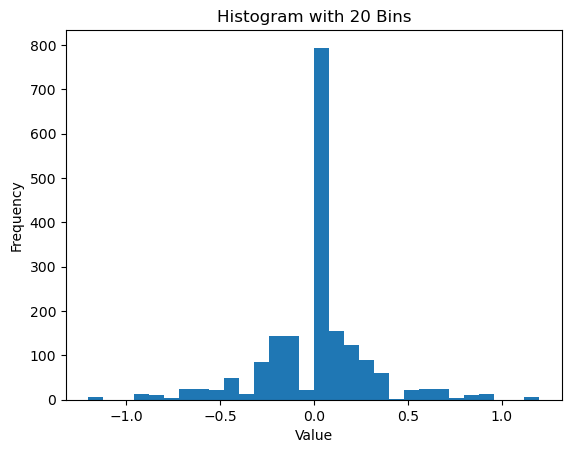

In [9]:
plt.hist(y, bins=30)
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Histogram with 20 Bins")
plt.show()

## 3. Model Training & Validation

In [10]:
# Split the training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=40)

In [11]:
y_train

323    -0.1
1412    0.0
1811    0.4
365    -0.3
753     0.0
       ... 
1016   -0.3
165     0.0
7       0.0
219    -0.3
1350    0.0
Name: Turn, Length: 1417, dtype: float64

In [12]:
k = 30
k_best = SelectKBest(score_func=f_regression, k=k)
k_best.fit(X_train, y_train)

selected_feature_indices = k_best.get_support(indices=True)
print("selected_feature_indices: ", selected_feature_indices)

selected_feature_indices:  [ 22  23  24  25  26  27  28  29  30  31  32  33  34  35 322 323 324 325
 326 327 328 329 330 331 332 333 334 335 336 337]


In [13]:
# Create a random forest regressor
rf = RandomForestRegressor(n_estimators=200, random_state=42)

In [14]:
# Train the model on the training data
rf.fit(X_train.iloc[:, selected_feature_indices], y_train)

RandomForestRegressor(n_estimators=200, random_state=42)

In [15]:
X_test.iloc[:, selected_feature_indices].shape

(473, 30)

In [16]:
# Make predictions on the testing data
y_pred = rf.predict(X_test.iloc[:, selected_feature_indices])

In [17]:
# Calculate the mean squared error of the predictions
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.03438238026267974


In [18]:
# Calculate the R-squared value of the predictions
r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)

R-squared: 0.5638647986396059


## 4. Export the Model

In [19]:
import pickle
# Save the model to disk
filename = 'self_driving_model_0.2.pkl'
with open(filename, 'wb') as file:
    pickle.dump(rf, file)